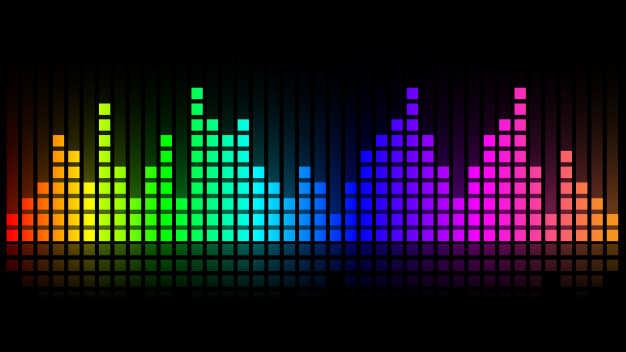



## Classification of Sound.

- This kernel is an introduction to working with sound data and it's classification using Convolutional Neural Network. It's just a basic kernel
which will guide you to how to get started with sound data. The kernel will be constantly updated.

- The main aim is to create a satisfactory model and make some decent predictions.

- The Basics of Librosa isn't complete yet, so let it be please.



### Importing the Libraries

In [ ]:
!pip install python_speech_features

In [ ]:
import librosa
from python_speech_features import mfcc, logfbank
from scipy.io import wavfile

import librosa.display
# import mir_eval

## For playing sound in Notebook.
import IPython.display as ipd 

from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

### Basics of Librosa.

In [ ]:
y,sr = librosa.load(librosa.util.example_audio_file())

In [ ]:
print(type(y), type(sr))
print(y.shape, sr)

In [ ]:
ipd.Audio(data = y, rate = sr)

In [ ]:
## Waveform.

librosa.display.waveplot(y, sr);

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [ ]:
# n_mels = 128
# mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

In [ ]:
# plt.figure(figsize=(15, 4));

# plt.subplot(1, 3, 1);
# librosa.display.specshow(mel, sr=sr, hop_length=hop_length, x_axis='linear');
# plt.ylabel('Mel filter');
# plt.colorbar();
# plt.title('1. Our filter bank for converting from Hz to mels.');

# plt.subplot(1, 3, 2);
# mel_10 = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)
# librosa.display.specshow(mel_10, sr=sr, hop_length=hop_length, x_axis='linear');
# plt.ylabel('Mel filter');
# plt.colorbar();
# plt.title('2. Easier to see what is happening with only 10 mels.');

# plt.subplot(1, 3, 3);
# idxs_to_plot = [0, 9, 49, 99, 127]
# for i in idxs_to_plot:
#     plt.plot(mel[i]);
# plt.legend(labels=[f'{i+1}' for i in idxs_to_plot]);
# plt.title('3. Plotting some triangular filters separately.');

# plt.tight_layout();

## Getting into DATA.

In [ ]:
train = pd.read_csv('../input/freesound-audio-tagging/train.csv')
x = pd.read_csv('../input/freesound-audio-tagging/train_post_competition.csv')
y = pd.read_csv('../input/freesound-audio-tagging/test_post_competition.csv')
sample_sub = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')

In [ ]:
train.head()

In [ ]:
x.head()

In [ ]:
y.head()

In [ ]:
sample_sub.head()

In [ ]:
## Run this and verify the graph if you want.
# train['label'].value_counts()

In [ ]:
train['label'].nunique()

In [ ]:
a,b = np.unique(train.label,return_counts = True)

In [ ]:
trace = go.Bar(x = a, y = b)
data = [trace]
layout = {"title":"Number of Labels for Each category.",
         "xaxis":{"title":"Categories","tickangle":90},
         "yaxis":{"title":"Amount of labels"}}
fig = go.Figure(data = data,layout=layout)
iplot(fig)

In [ ]:

## Need to combine the values in DataFrame for plotting.
d = {'Labels': a, 'Samples':b}
new = pd.DataFrame(data = d)


## Visualizing the Data. 
## px: Plotly Express.

fig = px.bar(new[['Labels', 'Samples']].sort_values('Samples', ascending = True), 
             y = "Samples", x = "Labels", color = 'Labels', 
             log_y=True, template='ggplot2', title = "Number of Labels for Each category.")
fig.show()

**There's a lot of class imbalance.**

### Reading Audio Samples.

In [ ]:
fname = '../input/freesound-audio-tagging/audio_train/' + '00044347.wav'
ipd.Audio(fname)

In [ ]:
fname = '../input/freesound-audio-tagging/audio_train/' + '0033e230.wav'   
ipd.Audio(fname)

## Audio Analysis.

1. **FFT**: A fast Fourier transform (FFT) is an algorithm that computes the discrete Fourier transform (DFT) of a sequence, or its inverse (IDFT). Fourier analysis    converts a signal from its original domain (often time or space) to a representation in the frequency domain and vice versa. 

5. **MFCCS** : Mel Frequency cepstral coefficients

### [Mel-frequency cepstrum](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

- In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

- **Mel-frequency cepstral coefficients (MFCCs)** are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). 

- The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, **the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum.**

#### [What is Mel Scale ?](https://en.wikipedia.org/wiki/Mel_scale)

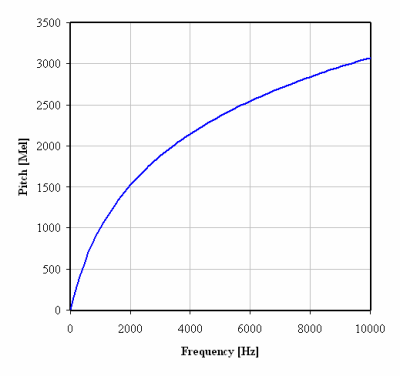

- The mel scale, named by Stevens, Volkmann, and Newman in 1937 is a perceptual scale of pitches judged by listeners to be equal in distance from one another. 

- The reference point between this scale and normal frequency measurement is defined by assigning a perceptual pitch of 1000 mels to a 1000 Hz tone, 40 dB above the listener's threshold. 

- The name mel comes from the word melody to indicate that the scale is based on pitch comparisons.

- See the comparison of mel scale with frequency in heartz in the image above to get a sense of the scale parameters. 

#### MFCCs are commonly derived as follows:

1. Take the Fourier transform of (a windowed excerpt of) a signal.
2. Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
3. Take the logs of the powers at each of the mel frequencies.
4. Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
5. The MFCCs are the amplitudes of the resulting spectrum.
6.  There can be variations on this process, for example: differences in the shape or spacing of the windows used to map the scale,or addition of dynamics features such as "delta" and "delta-delta" (first- and second-order frame-to-frame difference) coefficients.

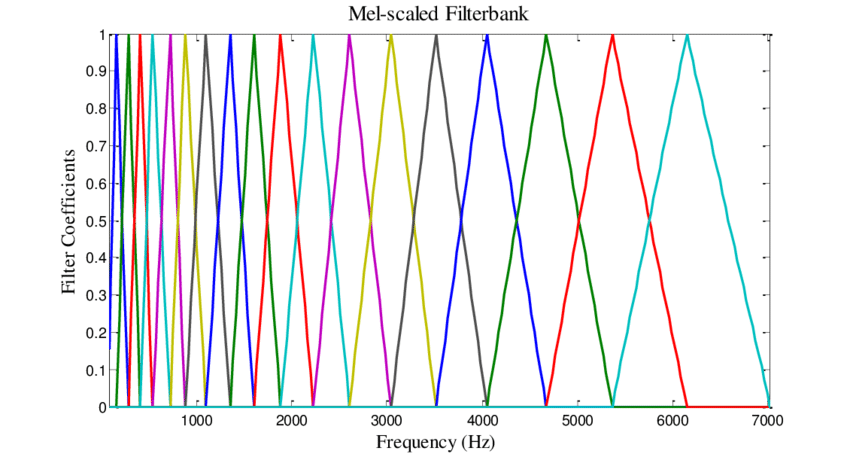

In [ ]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows = 8, ncols = 5, sharex = False, 
                            sharey = True, figsize = (20,15))
    fig.suptitle('Time Series', size = 16)
    i = 0
    for x in range(8):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            
def plot_fft(fft):
    fig, axes = plt.subplots(nrows = 8, ncols = 5, sharex = False, 
                            sharey = True, figsize = (20,15))
    fig.suptitle('Fourier Transform', size = 16)
    i = 0
    for x in range(8):
        for y in range(5):
            data = list(fft.values())[i]
            Y,freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            
def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows = 8, ncols = 5, sharex = False, 
                            sharey = True, figsize = (20,15))
    fig.suptitle('Filter Bank Coefficients', size = 16)
    i = 0
    for x in range(8):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],
                            cmap = 'hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
            
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows = 8, ncols = 5, sharex = False, 
                            sharey = True, figsize = (20,15))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size = 16)
    i = 0
    for x in range(8):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                            cmap = 'hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

In [ ]:
def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d = 1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

classes = list(np.unique(train.label))


signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = train[train.label == c].iloc[0,0]
    signal, rate = librosa.load('../input/freesound-audio-tagging/audio_train/' + wav_file, sr = 44100)
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt = 26, nfft = 1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep = 13, nfilt = 26, nfft = 1103).T
    mfccs[c] = mel
    
    
plot_signals(signals)
plt.show()

**Traditionally while creating this for production the dead noises should be cleaned out before using these files for modelling. By dead noises I mean the trail (Straight dead lines in the graph) of the graph.**

In [ ]:
plot_fft(fft)
plt.show()

In [ ]:
plot_fbank(fbank)
plt.show()

In [ ]:
plot_mfccs(mfccs)
plt.show()

### Cleaning Audio Files

In [ ]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window = int(rate/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [ ]:
for c in classes:
    wav_file = train[train.label == c].iloc[0,0]
    signal, rate = librosa.load('../input/freesound-audio-tagging/audio_train/' + wav_file, sr = 44100)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt = 26, nfft = 1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep = 13, nfilt = 26, nfft = 1103).T
    mfccs[c] = mel
    
    
plot_signals(signals)
plt.show()

**These here are somewhat clean and has the important part which can help in classification.**

- These file should be stored and used for modelling.

### References:

1. [Beginner's Guide to Audio Data](https://www.kaggle.com/fizzbuzz/beginner-s-guide-to-audio-data)

2. [Deep Learning for Audio Classification](https://youtu.be/Z7YM-HAz-IY)

3. [Practical Cryptography](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)

4. [source of cover image](https://www.freepik.com/premium-vector/sound-wave-display-equalizer-rainbow-color-illustration-about-dynamic-audio-from-electronic-equipment_5840116.htm)

5. [source of Mel filter bank image](https://www.researchgate.net/figure/Mel-filter-banks-basis-functions-using-20-Mel-filters-in-the-filter-bank_fig1_288632263)

6. [Python_specch_features Documentation](https://python-speech-features.readthedocs.io/en/latest/)

7. [librosa Github](https://github.com/librosa/librosa)